# Requirements

In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns
import geoplot
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import sddk

In [2]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

Your ScienceData username (e.g. '123456@au.dk'): 648597@au.dk
Your ScienceData password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [6]:
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict")
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import dataset

In [7]:
LIRE = s.read_file("SDAM_data/social_diversity/LIRE_occupsorgs_2021-08-31.geojson", "gdf")
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,occups,occups_N,organizations,organizations_N,curator,geometry
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,...,minor,0.097513,honorific inscription,1.0,[],0,[],0,[],POINT (20.76680 39.45120)
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,big,0.004249,mile-/leaguestone,1.0,[],0,[],0,[],POINT (22.41710 37.43190)
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,big,0.004249,public legal inscription,1.0,[],0,[],0,[],POINT (22.41710 37.43190)
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"['litterae erasae', 'tituli sacri']",tituli sacri,...,minor,0.520308,votive inscription,1.0,[],0,[],0,[],POINT (24.83230 37.81880)
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"['Archea Olimpia', 'Archaia Olympia', 'Olympia']",96,,{},{},...,minor,0.262624,owner/artist inscription,1.0,[],0,[],0,[],POINT (21.62710 37.64790)


# Occupations and organizations in urban vs rural context

### Buffers

In [8]:
# OCCUPATIONS frequency accross location categories
for context in ["big", "middle", "rest"]:
    print(context, LIRE[LIRE["urban_context"]==context]["occups_N"].sum() / len(LIRE[LIRE["urban_context"]==context]))

big 0.05032925682031985
middle 0.038016734469098076
rest 0.020021173246979697


### results from previous version
* big 0.03826332365331916
* middle 0.02797960597608854
* rest 0.015475152571926765

In [9]:
# ORGANIZATIONS frequency accross location categories
for context in ["big", "middle", "rest"]:
    print(context, LIRE[LIRE["urban_context"]==context]["organizations_N"].sum() / len(LIRE[LIRE["urban_context"]==context]))

big 0.019346394535563825
middle 0.011724787266170435
rest 0.006414248349732221


### results from previous version
big 0.03106466522148145
middle 0.01952354728109289
rest 0.010306389338647403

# Bootstrap test

Brezina 2018, p. 232, drawing on Lijffijt 2016
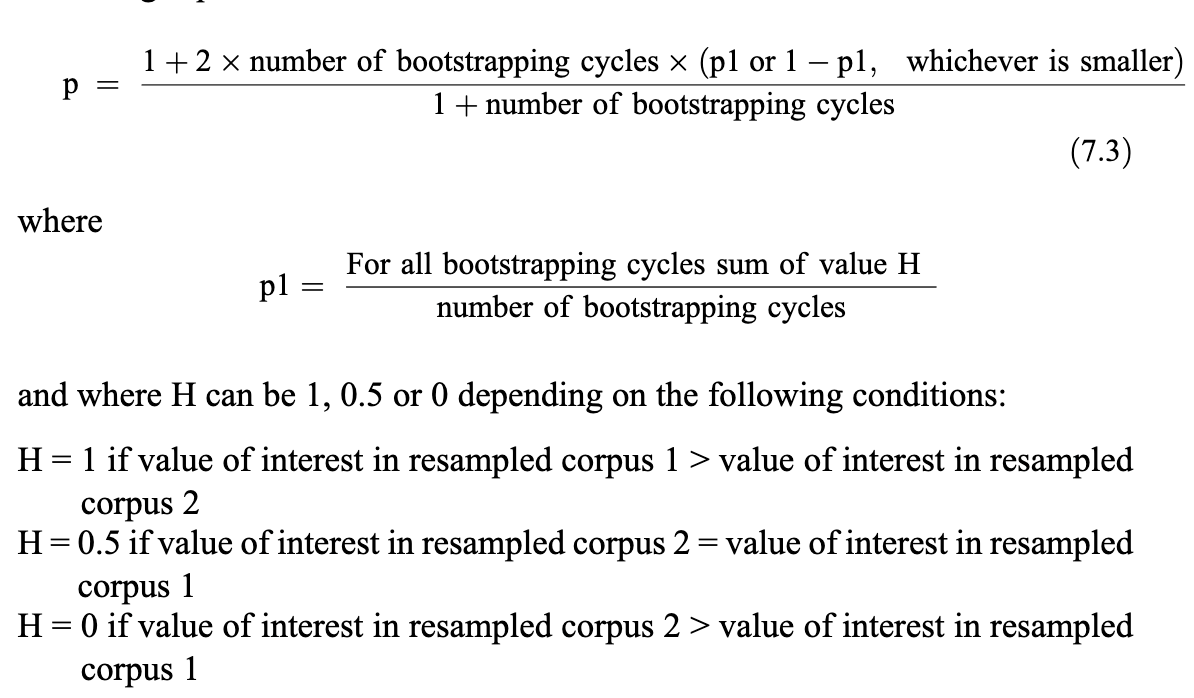

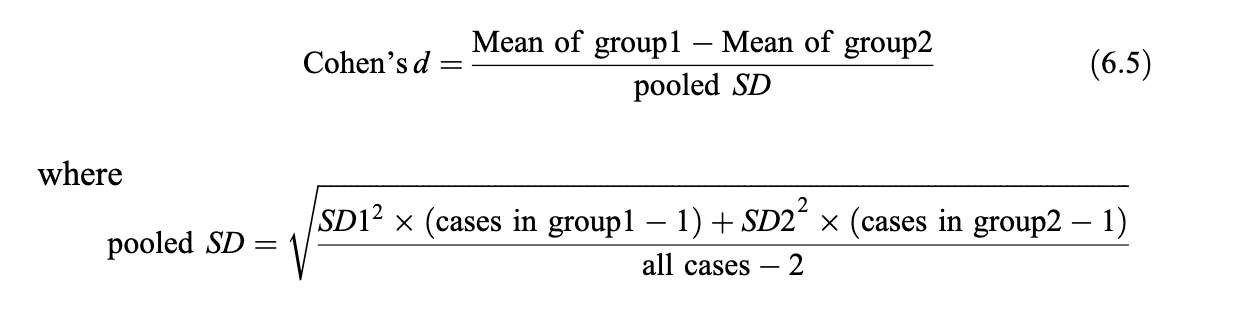

In [10]:
def get_bootstrap(df, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_values = []
    for n in range(n_of_bootstraps):
        sample_df = df.sample(bootstrap_size, replace=True)
        if row_function == None:
            bootstrap_values.append(sample_df[column].sum())
        else:
            bootstrap_values.append(sample_df[column].apply(row_function).mean())
    return bootstrap_values

def get_statistics(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_test_values = []
    df1_values = get_bootstrap(df1, n_of_bootstraps, bootstrap_size, column, row_function)
    df2_values = get_bootstrap(df2, n_of_bootstraps, bootstrap_size, column, row_function)
    # H values
    H_list = []
    for n in range(n_of_bootstraps):
        if df1_values[n] == df2_values[n]:
            H_list.append(0.5)
        else:
            if df1_values[n] > df2_values[n]:
                H_list.append(1)
            else:
                H_list.append(0)
    # CONFIDENCE INTERVAL (950) for the difference
    difference = np.array(df1_values) - np.array(df2_values)
    CI95 = (np.percentile(difference, 2.5), np.percentile(difference, 97.5))
    # COHENS DELTA
    pooled_sd = np.sqrt(((len(df1_values) - 1) * ((np.std(df1_values)**2))) + ((len(df2_values) - 1) * (np.std(df2_values)**2)) / (len(df1_values) + len(df2_values) + 2))
    cohens_delta = (np.mean(df1_values) - np.mean(df2_values)) / pooled_sd
    return H_list, cohens_delta, CI95, [df1_values, df2_values]

def bootstrap_test(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    H_values, cohens_delta, CI95, data = get_statistics(df1, df2, 1000, 1000, "occups_N", row_function)
    p1 =  sum(H_values) / len(H_values)
    p = (1 + (2 * len(H_values) * np.min((p1, 1 - p1)))) / (1 + len(H_values))
    return p, cohens_delta, CI95, data

In [11]:
# test1 "get_bootstrap()"
df1_values = get_bootstrap(LIRE[LIRE["urban_context"]=="big"], 1000, 1000, "occups_N")
df2_values = get_bootstrap(LIRE[LIRE["urban_context"]=="middle"], 1000, 1000, "occups_N")

print(df1_values[:10])
print(df2_values[:10])

[51, 49, 58, 54, 65, 66, 53, 44, 53, 39]
[48, 26, 42, 41, 45, 26, 51, 42, 30, 21]


### Occupations

In [12]:
# LIRE - occupations in BIG CITIES vs MIDDLE CITIES
p, cohens_d, CI95, edhcs_data_occups_big_middle = bootstrap_test(LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="middle"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.3566433566433568, 0.03744437761649797, (-13.0, 40.0))

In [13]:
# LIRE - occuptions in MIDDLE CITIES vs. REST areas
p, cohens_d, CI95, edhcs_data_occups_middle_rest = bootstrap_test(LIRE[LIRE["urban_context"]=="middle"], LIRE[LIRE["urban_context"]=="rest"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.06993006993006988,
 0.06870604008291548,
 (-1.0249999999999986, 38.02499999999998))

In [14]:
# LIRE - occupations in BIG CITIES vs REST areas
p, cohens_d, CI95, edhcs_data_occups_big_rest = bootstrap_test(LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="rest"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.0029970029970029987, 0.10024374310616647, (10.0, 52.0))

### Organizations

In [15]:
# LIRE - organizations in BIG CITIES vs MIDDLE CITIES
p, cohens_d, CI95, edhcs_data_orgs_big_middle = bootstrap_test(LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="middle"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.37362637362637363, 0.03749262258496107, (-13.0, 40.0))

In [16]:
# LIRE - organizations in MIDDLE CITIES vs. REST areas
p, cohens_d, CI95, edhcs_data_orgs_middle_rest = bootstrap_test(LIRE[LIRE["urban_context"]=="middle"], LIRE[LIRE["urban_context"]=="rest"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.048951048951048994, 0.07132974246305081, (0.0, 37.02499999999998))

In [17]:
# LIRE - organizations in BIG CITIES vs. REST areas
p, cohens_d, CI95, edhcs_data_orgs_big_rest = bootstrap_test(LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="rest"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.0029970029970029987, 0.09386924466103698, (8.0, 55.0))

In [18]:
labels=[
    "cities (pop.≥30K)",
    "cities (pop.>1K)",
    "rural or minor cities"
]

In [19]:
stat_series = []
for label, data in zip(labels, edhcs_data_occups_big_middle + [edhcs_data_occups_middle_rest[1]]):
    stat_series.append(pd.Series(data).describe())
    
for label, data in zip(labels, edhcs_data_orgs_big_middle + [edhcs_data_orgs_middle_rest[1]]):
    stat_series.append(pd.Series(data).describe())
    

In [20]:
contexts = labels + labels
contexts  = [context.replace("\n", " ") for context in contexts]
measurements = ["occups. per 1,000 ins."] * 3 + ["orgs. per 1,000 ins."] * 3

occups_orgs_contexts_descriptive = pd.DataFrame([measurements, contexts], index=["measurement","context"]).T.join(pd.DataFrame(stat_series))

for col in ["count",  "min", "25%", "50%", "75%", "max"]:
    occups_orgs_contexts_descriptive[col] = occups_orgs_contexts_descriptive[col].astype(int)
occups_orgs_contexts_descriptive.drop("count", inplace=True, axis=1)
#occups_orgs_contexts_descriptive.rename(columns={"count" : "N of bootstraps"}, inplace=True)
occups_orgs_contexts_descriptive = occups_orgs_contexts_descriptive.round(2)
occups_orgs_contexts_descriptive

,measurement,context,mean,std,min,25%,50%,75%,max
0,"occups. per 1,000 ins.",cities (pop.≥30K),50.45,10.37,23,44,50,56,103
1,"occups. per 1,000 ins.",cities (pop.>1K),38.18,8.41,12,33,38,43,73
2,"occups. per 1,000 ins.",rural or minor cities,19.88,5.65,5,16,20,23,41
3,"orgs. per 1,000 ins.",cities (pop.≥30K),49.97,9.98,19,43,49,57,98
4,"orgs. per 1,000 ins.",cities (pop.>1K),38.14,8.36,18,32,37,43,77
5,"orgs. per 1,000 ins.",rural or minor cities,20.25,5.63,2,16,20,24,42


In [21]:
print(occups_orgs_contexts_descriptive.to_latex(index=False, bold_rows=True, multirow=True))

\begin{tabular}{llrrrrrrr}
\toprule
            measurement &                context &   mean &    std &  min &  25\% &  50\% &  75\% &  max \\
\midrule
 occups. per 1,000 ins. &      cities (pop.≥30K) &  50.45 &  10.37 &   23 &   44 &   50 &   56 &  103 \\
 occups. per 1,000 ins. &       cities (pop.>1K) &  38.18 &   8.41 &   12 &   33 &   38 &   43 &   73 \\
 occups. per 1,000 ins. &  rural or minor cities &  19.88 &   5.65 &    5 &   16 &   20 &   23 &   41 \\
   orgs. per 1,000 ins. &      cities (pop.≥30K) &  49.97 &   9.98 &   19 &   43 &   49 &   57 &   98 \\
   orgs. per 1,000 ins. &       cities (pop.>1K) &  38.14 &   8.36 &   18 &   32 &   37 &   43 &   77 \\
   orgs. per 1,000 ins. &  rural or minor cities &  20.25 &   5.63 &    2 &   16 &   20 &   24 &   42 \\
\bottomrule
\end{tabular}



In [22]:
occups_orgs_contexts_descriptive.to_csv("../data/occups_orgs_contexts_descriptive.csv")

In [24]:
# export to google sheets
set_with_dataframe(socdiv_results.add_worksheet("occups_orgs_contexts_descriptive", 1,1), occups_orgs_contexts_descriptive)

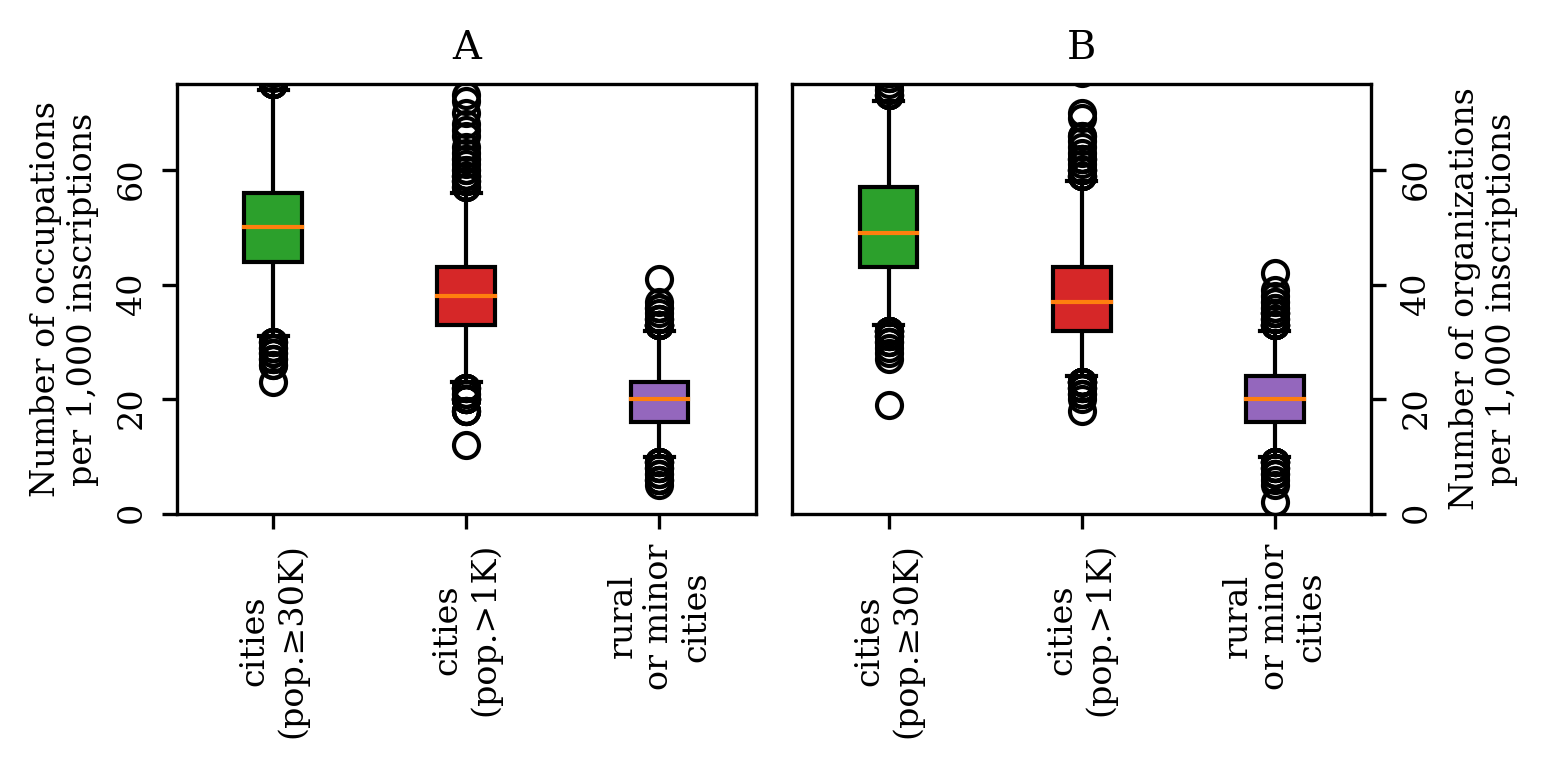

In [25]:

plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

labels=[
    "cities\n(pop.≥30K)",
    "cities\n(pop.>1K)",
    "rural\nor minor\ncities"
]

fig, [ax1, ax2] = plt.subplots(1,2, figsize=[5.2,2.6], tight_layout=True)

bplot1 = ax1.boxplot(edhcs_data_occups_big_middle + [edhcs_data_occups_middle_rest[1]], whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0,75)


bplot2 = ax2.boxplot(edhcs_data_orgs_big_middle + [edhcs_data_orgs_middle_rest[1]], whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax2.set_title("B")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_ylabel("Number of organizations\nper 1,000 inscriptions")
ax2.tick_params(labelrotation=90)
ax2.set_ylim(0,75)




# fill with colors
colors =tab_colors_list[2:][:len(labels)]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [26]:
s.write_file(figpath + "occups_orgs_by_context_box.eps", fig)
s.write_file(figpath + "occups_orgs_by_context_box.png", fig)

A file with the same name ("occups_orgs_by_context_box.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_orgs_by_context_box.eps"
A file with the same name ("occups_orgs_by_context_box.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_orgs_by_context_box.png"


# By industry type

In [27]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list.csv")
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Category"]))

In [28]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in eval(list_of_occups)]
    except:
        return []
    
LIRE["occups_cats"] = LIRE["occups"].apply(cat_for_occup)

In [29]:
edhcs_occups_cats_data = {}

labels=[
    "cities\n(pop.≥30K)",
    "cities\n(pop.>1K)",
    "rural\nor minor\ncities"
]

edhcs_all_present_categories = []
for df_subset, subset_title in zip([LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="middle"], LIRE[LIRE["urban_context"]=="rest"]], labels):
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edhcs_all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edhcs_occups_cats_data[subset_title] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

['Managerial', 'Metal-Working', 'Miscellaneous Services', 'Building', 'Education', 'Food-Production', 'Retail', 'Clothing', 'Transport', 'Performing Arts', 'Finance', 'Plastic Arts', 'Food-Retail', 'Household Goods', 'Water-Management', 'Glass-Working', 'Unclear meaning', 'Fuel / Raw material'] [9.608254266993743, 6.319216356263714, 5.831951480600006, 2.7865460077018303, 2.1926919404866863, 2.1622378857577043, 2.1165568036642317, 1.8729243658323778, 1.1877081344302884, 1.111572997607834, 0.5786270398506533, 0.5024919030281989, 0.487264875663708, 0.38067568411227193, 0.16749730100939964, 0.10658919155143615, 0.04568108209347263, 0.015227027364490876] 37.473714344012045
['Metal-Working', 'Managerial', 'Miscellaneous Services', 'Retail', 'Clothing', 'Building', 'Performing Arts', 'Education', 'Food-Production', 'Transport', 'Finance', 'Plastic Arts', 'Food-Retail', 'Household Goods', 'Water-Management', 'Unclear meaning', 'Glass-Working'] [9.880423893162748, 6.816726561949492, 3.477296470

In [30]:
edhcs_data_by_category = {}
for cat in edhcs_all_present_categories:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Metal-Working': [6.319216356263714, 9.880423893162748, 4.690546706548592],
 'Miscellaneous Services': [5.831951480600006,
  3.477296470927044,
  2.431225779834087],
 'Retail': [2.1165568036642317, 2.6041427315312666, 0.9823134463976111],
 'Transport': [1.1877081344302884, 0.8118797927715126, 0.6385037401584471],
 'Building': [2.7865460077018303, 1.5931226122308924, 1.4489123334364762],
 'Food-Production': [2.1622378857577043,
  1.0416570926125066,
  0.5893880678385666],
 'Clothing': [1.8729243658323778, 2.5275502982509352, 0.8349664294379693],
 'Education': [2.1926919404866863, 1.2101604458292357, 0.5402723955186861],
 'Managerial': [9.608254266993743, 6.816726561949492, 2.67680414143349],
 'Performing Arts': [1.111572997607834,
  1.3633453123898984,
  0.5893880678385666]}

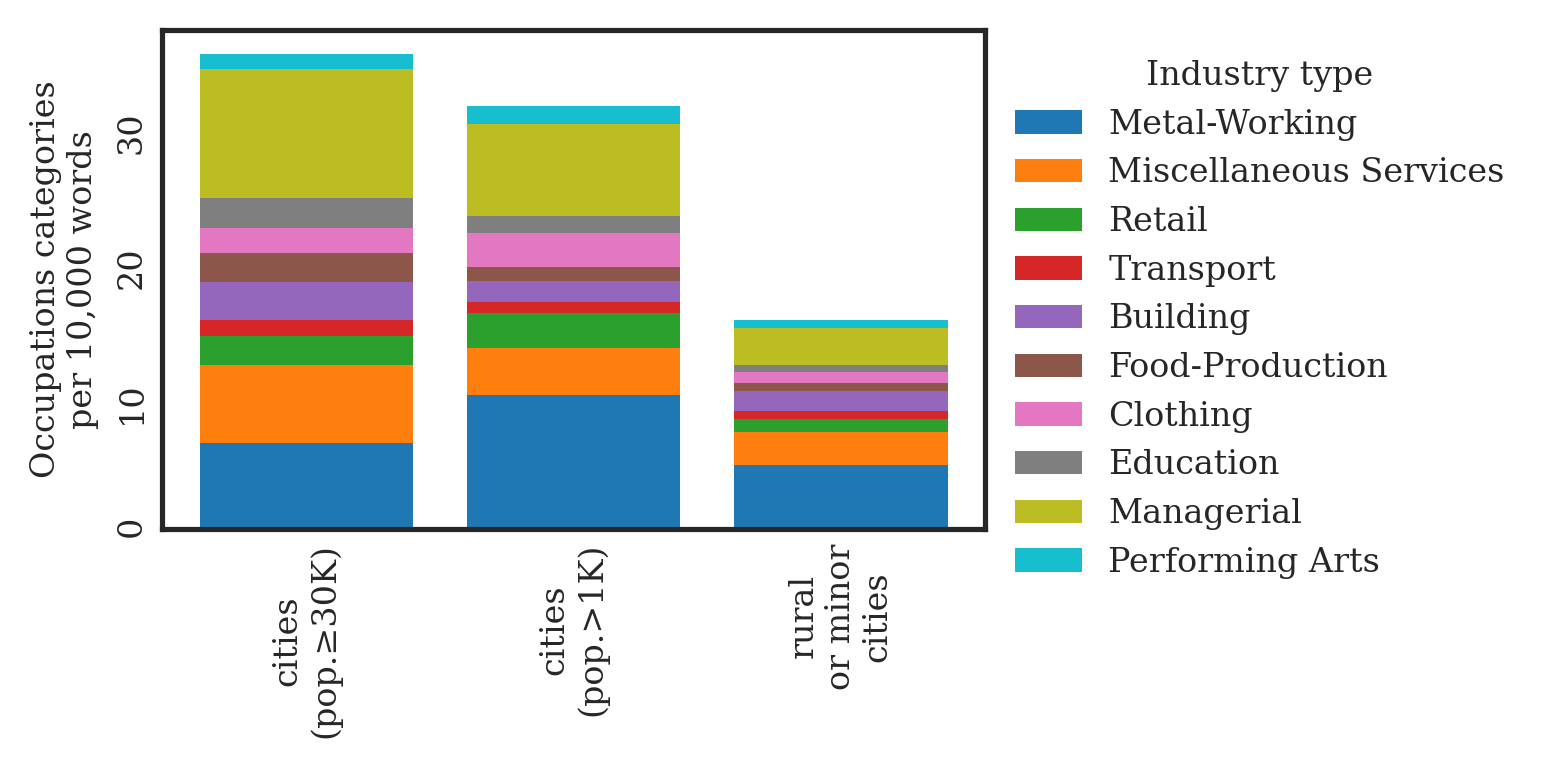

In [31]:
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=[5.2,2.6], tight_layout=True)
first_bar_cat = list(edhcs_data_by_category.keys())[0]
ax.bar(labels, edhcs_data_by_category[first_bar_cat], label=first_bar_cat)
bottom = edhcs_data_by_category[first_bar_cat]

ax.tick_params(labelrotation=90)

for cat in list(edhcs_data_by_category.keys())[1:]:
    ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupations categories\nper 10,000 words")
ax.legend(title="Industry type", bbox_to_anchor=(1, 1), fontsize=8)

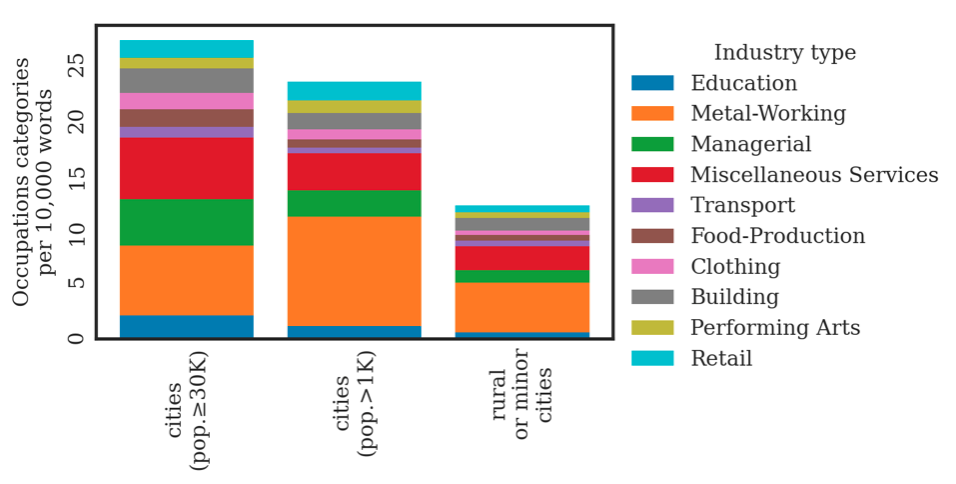

In [32]:
s.write_file(figpath + "occups_industrytypes_context_bar.eps", fig)
s.write_file(figpath + "occups_industrytypes_context_bar.png", fig)

A file with the same name ("occups_industrytypes_context_bar.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_context_bar.eps"
A file with the same name ("occups_industrytypes_context_bar.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_context_bar.png"
